In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from matplotlib.font_manager import FontProperties  
#-*- coding: utf-8 -*-

In [2]:
path = 'char3.jpg'

In [3]:
img = cv2.imread(path)

In [4]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [5]:
H,W = img.shape[:2]
H,W

(90, 112)

# 抗扭斜

<class 'numpy.ndarray'>


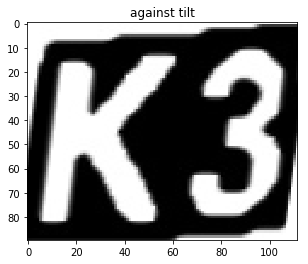

In [6]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*H*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(W, H),flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR,borderMode = cv2.BORDER_CONSTANT, borderValue=(255,255,255))
    #img = cv2.warpAffine(img,M,(W, H))
    return img

after = deskew(img)
plt.title('against tilt')
plt.imshow(after,'gray')
print(type(after))

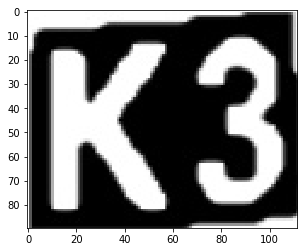

In [7]:
plt.imshow(img,'gray')

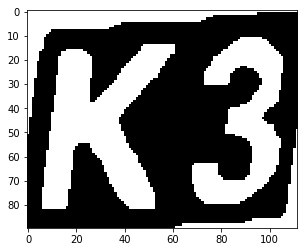

In [8]:
if path == 'char1.jpg':
    ret,binary = cv2.threshold(after,127,255,cv2.THRESH_BINARY_INV)
else:
    ret,binary = cv2.threshold(after,127,255,cv2.THRESH_BINARY)
plt.imshow(binary,'gray')

In [9]:
thresh1 = binary.copy()
(h,w)=thresh1.shape #返回高和宽
# print(h,w)#s输出高和宽
a = [0 for z in range(0, w)] 
#print(a) #a = [0,0,0,0,0,0,0,0,0,0,...,0,0]初始化一个长度为w的数组，用于记录每一列的黑点个数  
 
#记录每一列的波峰
for j in range(0,w): #遍历一列 
    for i in range(0,h):  #遍历一行
        if  thresh1[i,j]==0:  #如果该点为黑点
            a[j]+=1  		#该列的计数器加一计数
            thresh1[i,j]=255  #记录完后将其变为白色 
    # print (j)           
 
            
for j  in range(0,w):  #遍历每一列
    for i in range((h-a[j]),h):  #从该列应该变黑的最顶部的点开始向最底部涂黑
        thresh1[i,j]=0   #涂黑
 
# 此时的thresh1便是一张图像向垂直方向上投影的直方图
#如果要分割字符的话，其实并不需要把这张图给画出来，只需要的到a=[]即可得到想要的信息
 
 
# img2 =Image.open('0002.jpg')
# img2.convert('L')
# img_1 = np.array(img2)
print(h,w)

90 112


In [10]:
# 根据设定的阈值和图片直方图，找出波峰，用于分隔字符
def find_waves(threshold, histogram):
    up_point = -1  # 上升点
    is_peak = False
    if histogram[0] > threshold:
        up_point = 0
        is_peak = True
    wave_peaks = []
    for i, x in enumerate(histogram):
        if is_peak and x < threshold:
            if i - up_point > 2:
                is_peak = False
                wave_peaks.append((up_point, i))
        elif not is_peak and x >= threshold:
            is_peak = True
            up_point = i
    if is_peak and up_point != -1 and i - up_point > 4:
        wave_peaks.append((up_point, i))
    return wave_peaks


# 根据找出的波峰，分隔图片，从而得到逐个字符图片
def seperate_card(img, waves):
    part_cards = []
    for wave in waves:
        part_cards.append(img[:, wave[0]:wave[1]])
    return part_cards

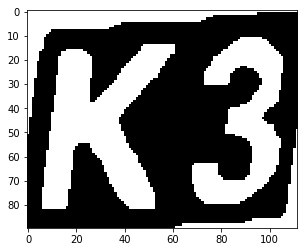

In [11]:
plt.imshow(binary,'gray')

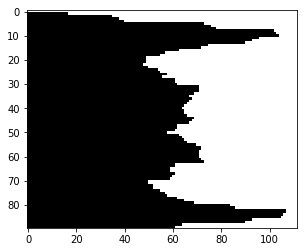

In [12]:
thresh2 = binary.copy()
(h,w)=thresh2.shape #返回高和宽
 
a = [0 for z in range(0, h)] 
 
for j in range(0,h):  
    for i in range(0,w):  
        if  thresh2[j,i]==0: 
            a[j]+=1 
            thresh2[j,i]=255
         
for j  in range(0,h):  
    for i in range(0,a[j]):   
        thresh2[j,i]=0    
 
plt.imshow(thresh2,cmap=plt.gray())
plt.show()


--------原图-----------


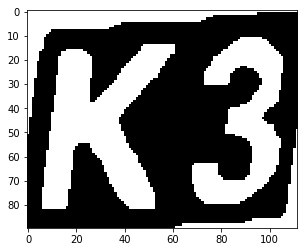

In [13]:
print('--------原图-----------')
plt.imshow(binary)

波峰点为: [(0, 8), (14, 82)]
长度为： 2
(14, 82)
8
82
水平裁剪前的图像尺寸为： (90, 112)
水平裁剪后的图像尺寸为： (74, 112)


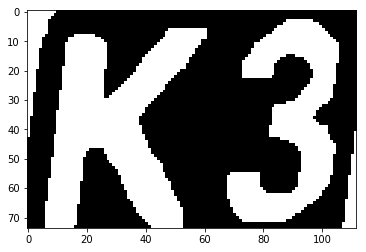

In [14]:
# 查找水平直方图波峰
gray_img = binary.copy()
x_histogram = np.sum(gray_img, axis=1)
x_min = np.min(x_histogram)
x_average = np.sum(x_histogram) / x_histogram.shape[0]
x_threshold = (x_min + x_average) / 2
wave_peaks = find_waves(x_threshold, x_histogram)
if len(wave_peaks) == 0:
    print("peak less 0:")
print('波峰点为:',wave_peaks)
print('长度为：',len(wave_peaks))
# 认为水平方向，最大的波峰为车牌区域
wave = max(wave_peaks, key=lambda x: x[1] - x[0])
wave1 = wave_peaks[0][1]
wave2 = wave_peaks[len(wave_peaks)-1][1]
print(wave)
print(wave1)
print(wave2)
gray_img = gray_img[wave1:wave2]
plt.imshow(gray_img)
print('水平裁剪前的图像尺寸为：',(h,w))
print('水平裁剪后的图像尺寸为：',gray_img.shape[:2])

In [15]:
# 查找垂直直方图波峰
# row_num, col_num = gray_img.shape[:2]
# print(row_num,col_num)
# # 去掉车牌上下边缘1个像素，避免白边影响阈值判断
# gray_img = gray_img[1:row_num - 1]
# plt.imshow(gray_img)
# print(gray_img.shape[:2])
# y_histogram = np.sum(gray_img, axis=0)
# y_min = np.min(y_histogram)
# y_average = np.sum(y_histogram) / y_histogram.shape[0]
# y_threshold = (y_min + y_average) / 5  # U和0要求阈值偏小，否则U和0会被分成两半
# wave_peaks = find_waves(y_threshold, y_histogram)
# print(len(wave_peaks))
# print('查找到的波峰点:',wave_peaks)

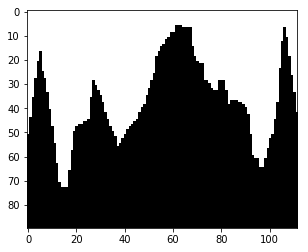

In [16]:
plt.imshow(thresh1,cmap=plt.gray())

74 112
(74, 110)


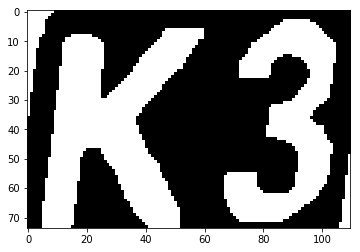

In [17]:
row_num, col_num = gray_img.shape[:2]
print(row_num,col_num)
gray_img = gray_img[:,1:col_num-1]
plt.imshow(gray_img)
print(gray_img.shape[:2])

74 110
72 110
(72, 108)
2
查找到的波峰点: [(0, 56), (66, 104)]


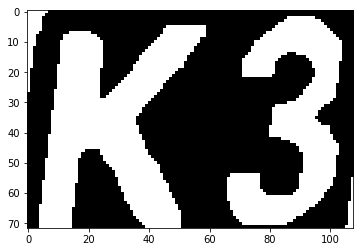

In [18]:
# 去掉车牌上下边缘1个像素，避免白边影响阈值判断
row_num, col_num = gray_img.shape[:2]
print(row_num,col_num)
gray_img = gray_img[1:row_num - 1]

# 去掉车牌左右边缘1个像素，避免白边影响阈值判断
row_num, col_num = gray_img.shape[:2]
print(row_num,col_num)
gray_img = gray_img[:,1:col_num - 1]

plt.imshow(gray_img)
print(gray_img.shape[:2])
y_histogram = np.sum(gray_img, axis=0)
y_min = np.min(y_histogram)
y_average = np.sum(y_histogram) / y_histogram.shape[0]
y_threshold = (y_min + y_average) / 5  # U和0要求阈值偏小，否则U和0会被分成两半
wave_peaks = find_waves(y_threshold, y_histogram)
print(len(wave_peaks))
print('查找到的波峰点:',wave_peaks)

In [19]:
#找到中值点
temp = 5000
for i,item in enumerate(wave_peaks):
    print(item[0])
    if abs(item[0]-col_num/2) < temp:
        temp = abs(item[0]-col_num/2) 
        mid_index = i    
mid_x = wave_peaks[mid_index][0] 
print('中间点是',len(wave_peaks),'个点中的第',mid_index+1,'个点')

if mid_index + 1 == len(wave_peaks):
    right_x = col_num
else:
    right_x = wave_peaks[mid_index+1][0]
print('最右x点为：',right_x)

if mid_index - 1 < 0:
    left_x = col_num
else:
    left_x = wave_peaks[mid_index-1][0]
print('最左x点为：',left_x)

0
66
中间点是 2 个点中的第 2 个点
最右x点为： 110
最左x点为： 0


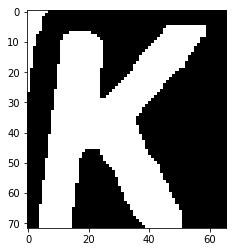

In [20]:
char1 = gray_img[:,left_x:mid_x]
char2 = gray_img[:,mid_x:right_x]
plt.imshow(char1)

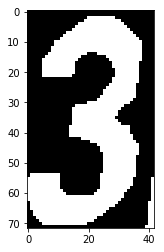

In [23]:
plt.imshow(char2)

In [24]:
part_cards = [char1,char2]
# print(part_cards)
def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n * ang / (2 * np.pi))
        bin_cells = bin[:10, :10], bin[10:, :10], bin[:10, 10:], bin[10:, 10:]
        mag_cells = mag[:10, :10], mag[10:, :10], mag[:10, 10:], mag[10:, 10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps
        samples.append(hist)
    return np.float32(samples)

    
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_RBF)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(1)
svm.setGamma(0.5)
SZ = 20
for i, part_card in enumerate(part_cards):
    part_card = preprocess_hog([part_card])
    print(part_card.shape)
    w = abs(part_card.shape[1] - SZ) // 2
    print(w)
    part_card = cv2.copyMakeBorder(part_card, 0, 0, w, w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    part_card = cv2.resize(part_card, (SZ, SZ), interpolation=cv2.INTER_AREA)
    resp = svm.predict(part_card)
    charactor = chr(resp[0])
    

(1, 64)
22


error: OpenCV(4.0.0) /io/opencv/modules/ml/src/svm.cpp:2010: error: (-215:Assertion failed) samples.cols == var_count && samples.type() == CV_32F in function 'predict'
